# Отчет анализа стоимости ювелирных изделий у ЭПЛ ДАЙМОНД
, дата парсинга -  06 июня 2022

##  Парсинг 
 С сайта https://epldiamond.ru/ были спарсены данные ювелирных издели предлагаемых на интернет магазине с фильтром - кольца одного артикула э0901кц04164200  - основной камнень бриллиант

Процесс парсинга, реализован в ручном режиме, расчет прейскуратной стоимости автоматом
бриллиантов в файле результат расчета прейскуранта в файле 'суммированы_брилл_EPL-63_ring_020-070ct.xlsx'



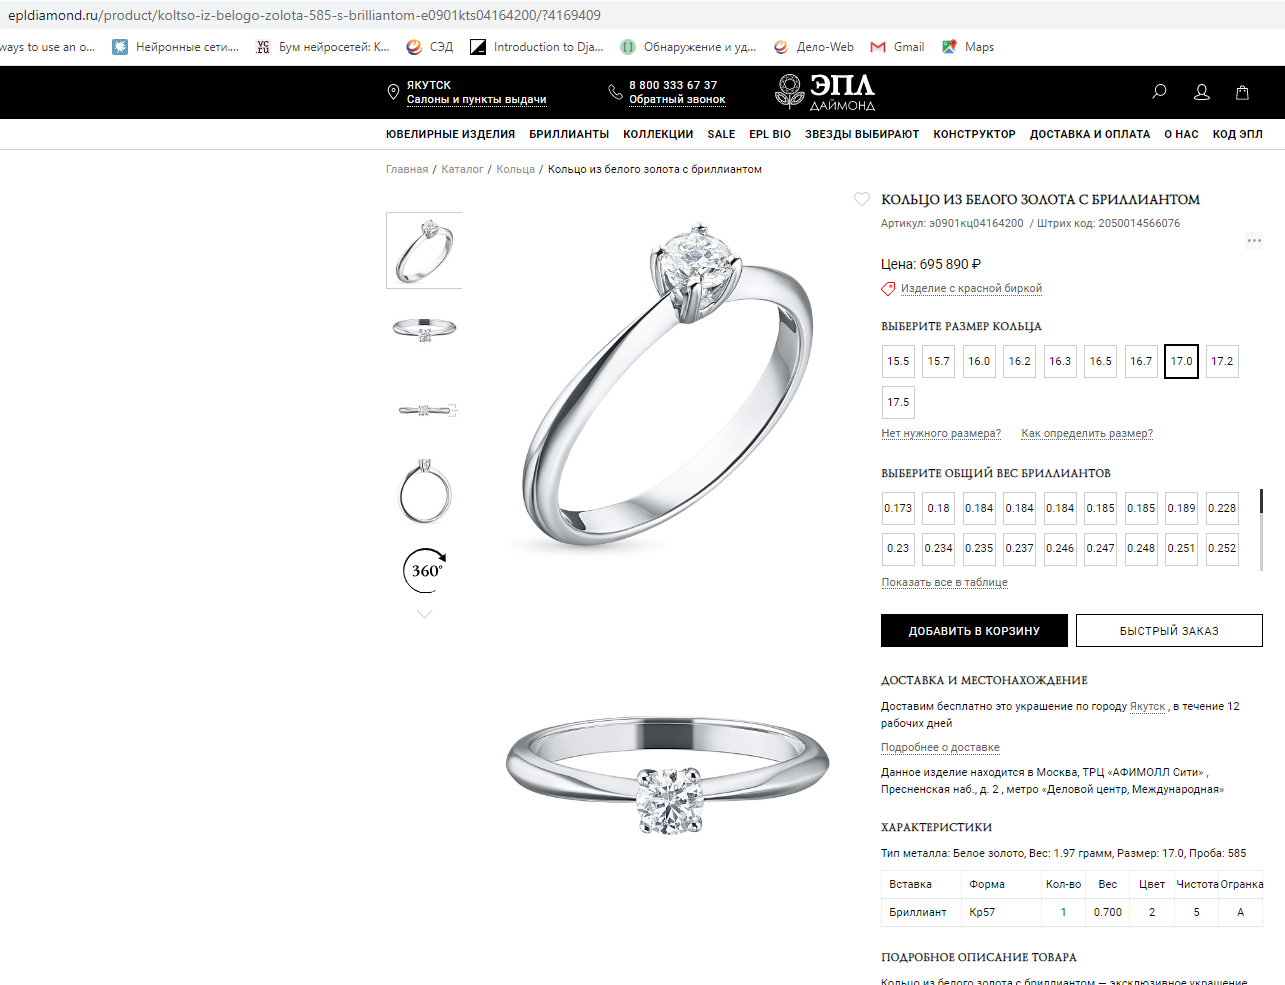

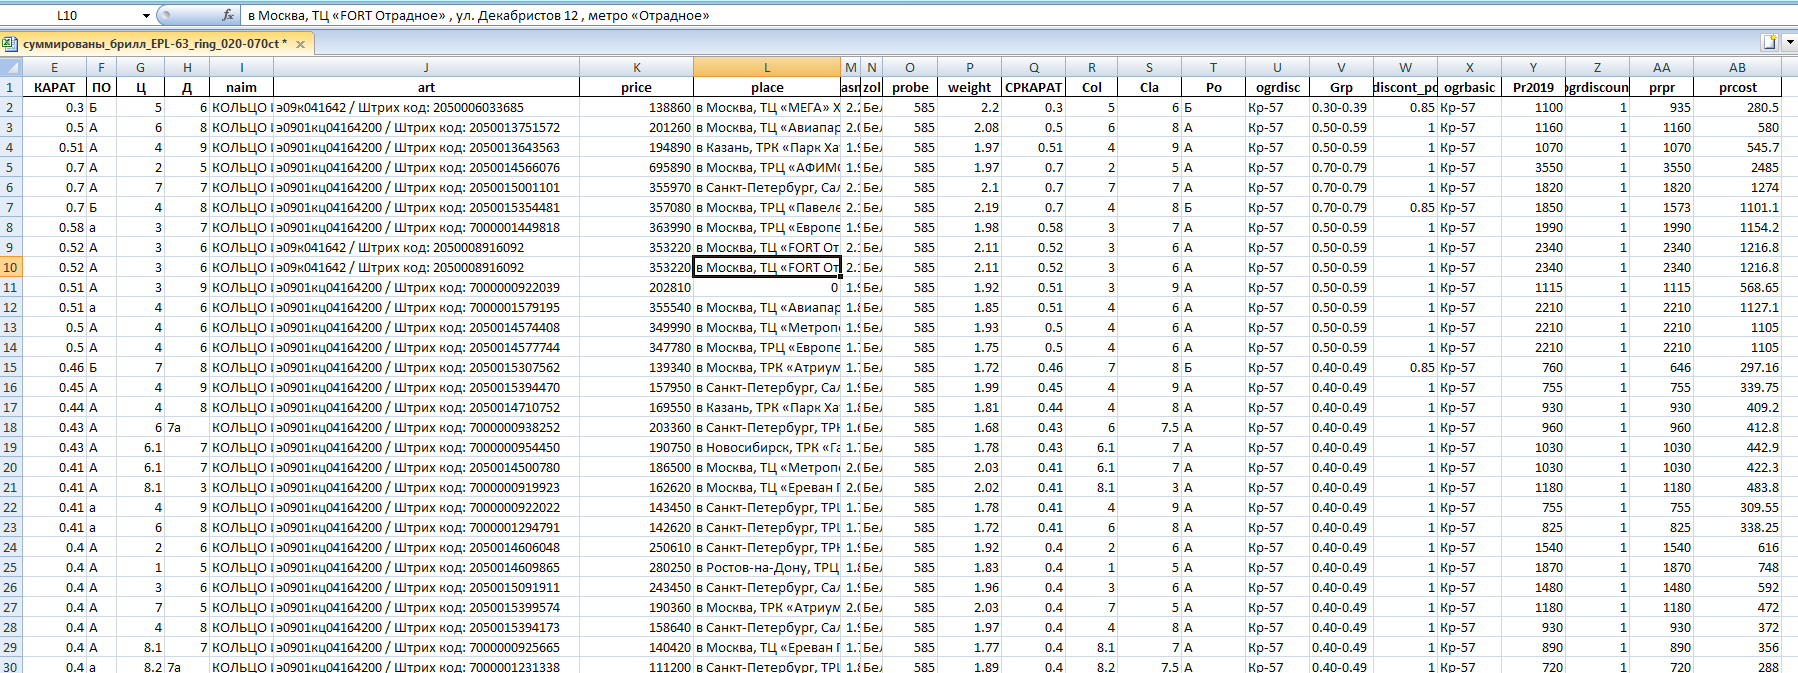

##  Анализ датасета ЭПЛ, визуализация, определение коэфициентов
###  Считывание данных с файла
Для этого устанавливаем необходимые модули.
 - загружаем данные с файла 
 - оставлены поля price : цена изделя, weight: масса изделия в граммах, prcost: прейскурант в долларах

In [1]:
import numpy as np
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
#%matplotlib inline
%matplotlib notebook
filenamemiuz =  'суммированы_брилл_EPL-63_ring_020-070ct.xlsx'
#'jewels/muiz04-2022/_брилл_суммированы_mius140422_0-4431.xlsx'
#'jewels/miuz/_брилл_суммированы_mius161121_0-3178.xlsx'
filepath = 'jewels/EPL06-06-22/'

In [2]:
filepath+filenamemiuz

'jewels/EPL06-06-22/суммированы_брилл_EPL-63_ring_020-070ct.xlsx'

In [3]:
raw = pd.read_excel(filepath+filenamemiuz)#,sheet_name=0)

In [5]:
#raw = raw.dropna(subset=["art"])

In [6]:
#ошибки парсинга - не прочитались данные
#len(raw.loc[raw.gold.isna()])

In [7]:
#raw = raw.dropna(subset=['gold'])

In [11]:
#raw.loc[raw.gold.str.contains('585')].head()
raw.columns

Index(['Unnamed: 0', 'gem', 'ОГРАНКА', 'ШТУК', 'КАРАТ', 'ПО', 'Ц', 'Д', 'naim',
       'art', 'price', 'place', 'rasm', 'zol', 'probe', 'weight', 'СРКАРАТ',
       'Col', 'Cla', 'Po', 'ogrdisc', 'Grp', 'discont_po', 'ogrbasic',
       'Pr2019', 'ogrdiscount', 'prpr', 'prcost'],
      dtype='object')

In [39]:
raw.loc[:39,['price','weight','prcost']]

,price,weight,prcost
40,85640,1.74,163.48
41,82970,1.77,155.55
42,82860,1.78,154.94
43,80920,1.63,154.94
44,83560,1.87,153.72
45,81380,1.72,153.11
46,81450,1.78,146.32
47,81990,1.84,145.73
48,81890,1.85,145.14
49,78480,1.77,139.83


In [54]:
data = raw.loc[:39,['price','weight','prcost']]#].loc[(raw.price<500000),:].loc[(raw.prcost<3000),:]
data.head()

,price,weight,prcost
0,138860,2.20,280.50
1,201260,2.08,580.00
2,194890,1.97,545.70
3,695890,1.97,2485.00
4,355970,2.10,1274.00


In [55]:
print(f'''Получен датасет с {len(data)} данными 
общая масса изделий {round(data.sum()['weight']/1000,2)} кг на сумму со скидкой и НДС {round(data.sum()['price']/1000000)} млн рублей 
с прейскурантной стоимостью  {round(data.sum()['prcost']/1000)}  тыс долл''') 

Получен датасет с 40 данными 
общая масса изделий 0.08 кг на сумму со скидкой и НДС 9 млн рублей 
с прейскурантной стоимостью  24  тыс долл


In [56]:
#сумма датасета
data.describe()

,price,weight,prcost
count,40.00,40.00,40.00
mean,214332.25,1.90,596.08
std,116558.97,0.14,454.18
min,88440.00,1.68,119.35
25%,140442.50,1.78,329.25
50%,166085.00,1.91,411.00
75%,258020.00,1.99,649.00
max,695890.00,2.20,2485.00


###  Визуализиация данных
Построим облако точек в трехмерной плоскости
- х вес золота в граммах
- y стоимость прейскурантная бриллиантов
- z стоимость изделия в тысячах рублей

Если покрутить график, то видно что точки стремятся к плоскости



In [43]:
%matplotlib notebook

<IPython.core.display.Javascript object>


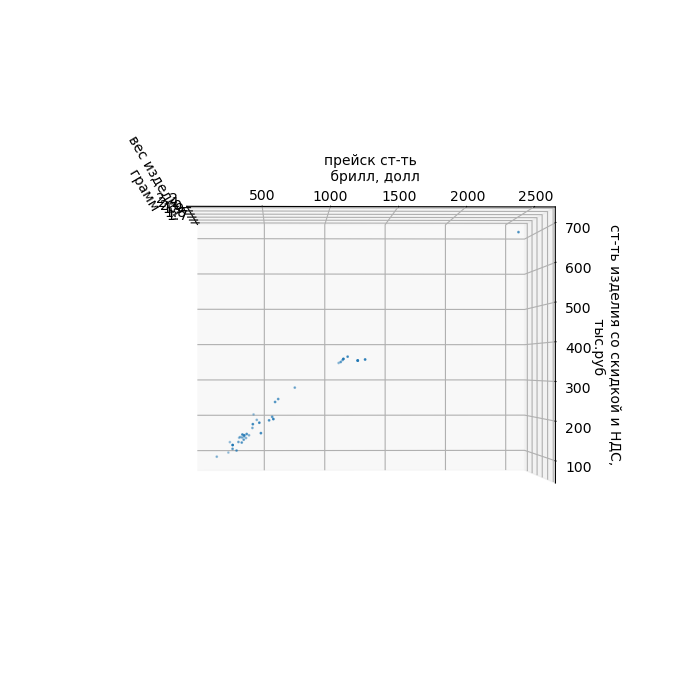

In [57]:
#
fig = plt.figure(figsize=(7,7))
ax = fig.gca(projection = "3d")
ax.scatter3D(data.weight,data.prcost,data.price/1000,s=1,c='#1f77b4')
ax.set_xlabel('вес изделия, \n грамм')
ax.set_ylabel('прейск ст-ть \n брилл, долл')
ax.set_zlabel('ст-ть изделия со скидкой и НДС,\n тыс.руб')
ax.view_init(45,0)
#todo 3 projection need

### Подготовка данных для определения коэффициентов  

Для того чтобы полученные коэффициенты имели интерпретируемый смысл, предлагается прейскурантную стоимость бриллиантов перевести в рубли, граммы золота перевести в биржевую стоимость золота, данного веса изделия в рублях. 

In [58]:
#Курс доллара и биржевая цена золота на 06-06-2022
dollar_rate = 72.10
gold_rate = 4300.0
#Курс доллара и биржевая цена золота на 19-04-2022
#dollar_rate = 80.36
#gold_rate = 5015.06
data['prcost_rub'] = data.prcost*dollar_rate
data['gold_rub'] = data.weight*0.585*gold_rate
pd.options.display.float_format ="{:.2f}".format
data.head()

,price,weight,prcost,prcost_rub,gold_rub
0,138860,2.20,280.50,20224.05,5534.10
1,201260,2.08,580.00,41818.00,5232.24
2,194890,1.97,545.70,39344.97,4955.53
3,695890,1.97,2485.00,179168.50,4955.53
4,355970,2.10,1274.00,91855.40,5282.55


<IPython.core.display.Javascript object>


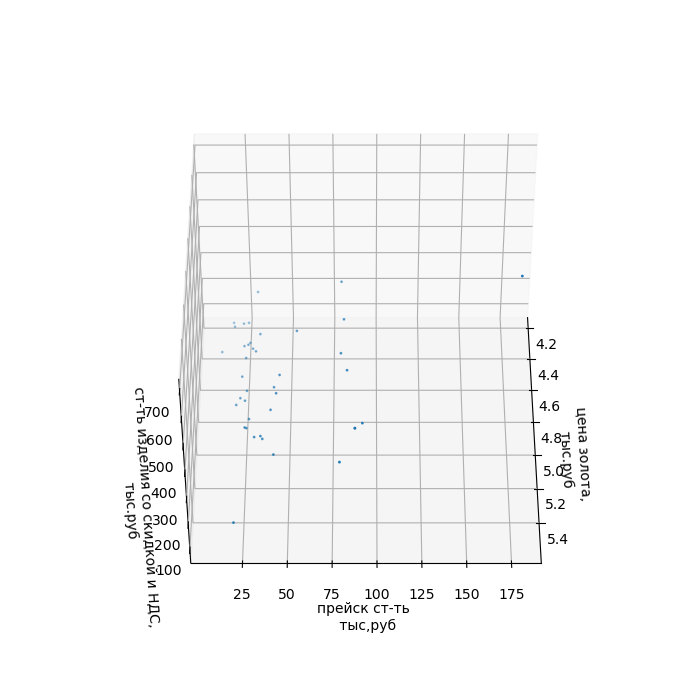

In [59]:
#новое графическое представление будеть иметь вид
fig2 = plt.figure(figsize=(7,7))
ax = plt.gca(projection = "3d")
ax.scatter3D(data.gold_rub/1000,data.prcost_rub/1000,data.price/1000,s=1,c='#1f77b4')
ax.set_xlabel('цена золота, \n тыс.руб')
ax.set_ylabel('прейск ст-ть \n тыс,руб')
ax.set_zlabel('ст-ть изделия со скидкой и НДС,\n тыс.руб')
ax.view_init(45,0)

Цена ювелирного изделия в первом приближении формируется линейной зависимостью, если обозначить за Z - цену издели, X - масса золота, Y - прейскурнтная стоимость бриллианов то можно записть закономерностю вида:

$$ Z = f(X,Y) = НДС*СКИДКА*НАЦЕНКА*\\(ПРОБА*БИРЖЕВАЯСТОИМОСТ*НАЦЕНКАЗОЛОТА*СЛОЖНОСТЬ*X\\ 
+НАЦЕНКАПРЕЙСКУРАНТ*СЛОЖНОСТЬ*Y+НАЦЕНКАБЕЗДКДМ) $$
можно раскрыть скобки, перемножить множители и мы получим уравнение вида:
$$ Z = A*X+B*Y+C $$
линейное уравнение такого вида в трехмерной плоскости является плоскостью, поэтому необходимо усредненную плоскость и найти эти три коэффициента.

###  Вычисление коэффициентов усредненой по облаку данных плоскости  

Для этого мы устанавливаем модуль отвечающий за расчеты линейной алгебры, и загружаем наши данные для расчета коэффициентов, и получаем коэффициенты



In [63]:
from sklearn import linear_model
#подготовка данных 
miuz = linear_model.LinearRegression()
X_train = data.iloc[:,:].loc[:,['gold_rub','prcost_rub']].to_numpy()
Y_train = data.iloc[:,:].loc[:,'price'].to_numpy()
miuz.fit(X_train,Y_train)
A,B = miuz.coef_
C =  miuz.intercept_
A,B,C

(-6.981986600297531, 3.5576429054920866, 94873.72485239453)

### Визуальная проверка полученных коэффициентов

In [61]:
#проверка
data['predict'] = miuz.predict(X_train)
data['bycoef'] = data.gold_rub*miuz.coef_[0] + data.prcost_rub*miuz.coef_[1]+miuz.intercept_
data['diff'] = data.predict-data.bycoef
data.head()

,price,weight,prcost,prcost_rub,gold_rub,predict,bycoef,diff
0,138860,2.20,280.50,20224.05,5534.10,128184.66,128184.66,0.00
1,201260,2.08,580.00,41818.00,5232.24,207115.81,207115.81,0.00
2,194890,1.97,545.70,39344.97,4955.53,200249.60,200249.60,0.00
3,695890,1.97,2485.00,179168.50,4955.53,697691.79,697691.79,0.00
4,355970,2.10,1274.00,91855.40,5282.55,384779.74,384779.74,0.00


Усредненная по нашим данным плоскость и коэффициенты посчитаны модулем по методу наименьних квадратов, постороим на плоскость построенной плоскости для проверки

<IPython.core.display.Javascript object>


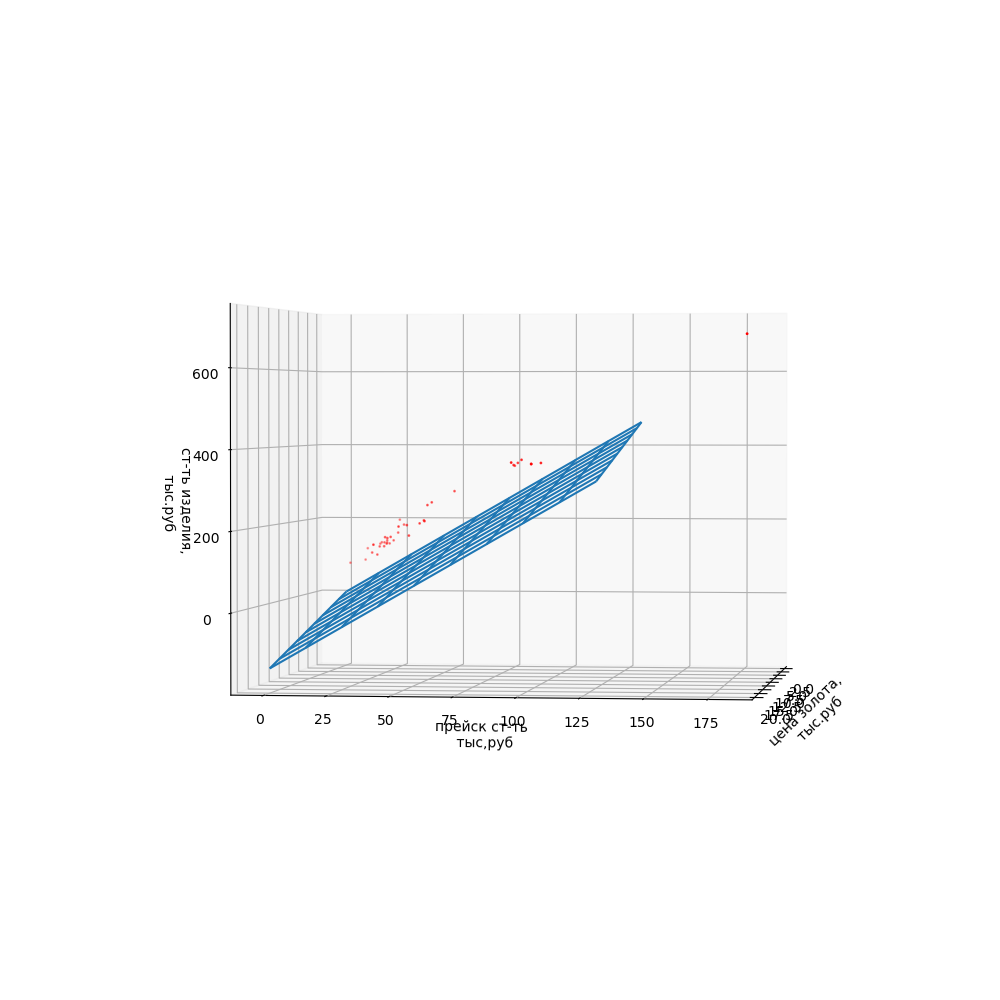

Text(0.5, 0, 'ст-ть изделия,\n тыс.руб')

In [64]:
x_val = np.linspace(0,20000,10)# np.arange(0, 20000,5000)
y_val = np.linspace(0,130000,10)
xx,yy = np.meshgrid(x_val,y_val)
zz = A*xx + B*yy + C/1000
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
ax.plot_wireframe(xx/1000, yy/1000, zz/1000 )
ax.scatter3D(data.gold_rub/1000,data.prcost_rub/1000,data.price/1000,s=1,c='red')
#ax.scatter3D(data.gold_rub/1000,data.prcost_rub/1000,data.predict/1000,s=1,c='red')
#ax.scatter3D(data.gold_rub/1000,data.prcost_rub/1000,data.bycoef/1000,s=1,c='green')
ax.set_xlabel('цена золота, \n тыс.руб')
ax.set_ylabel('прейск ст-ть \n тыс,руб')
ax.set_zlabel('ст-ть изделия,\n тыс.руб')
#ax.plot_surface(xx/1000, yy/1000, zz/1000)

<IPython.core.display.Javascript object>


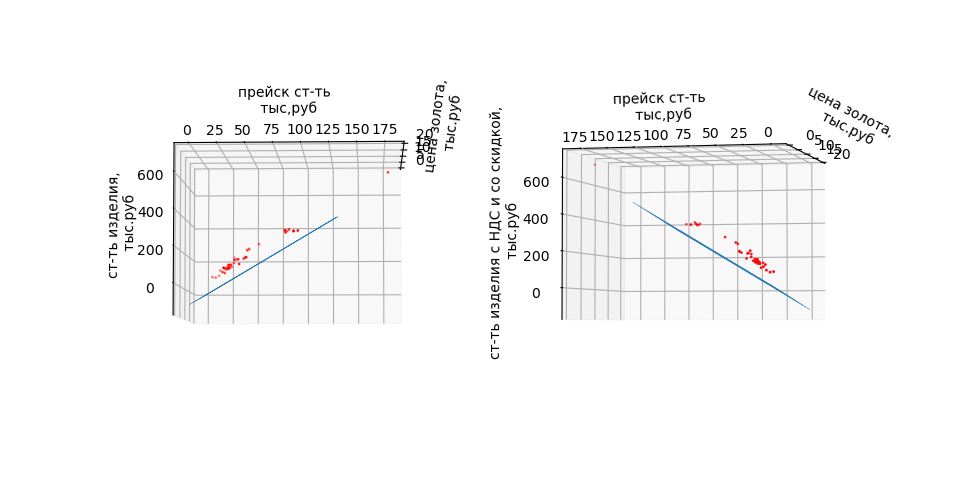

In [37]:
fig = plt.figure(figsize=plt.figaspect(0.5))

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_wireframe(xx/1000, yy/1000, zz/1000, linewidth=0.2 )
ax.scatter3D(data.gold_rub/1000,data.prcost_rub/1000,data.price/1000,s=1,c='red')
ax.set_xlabel('цена золота, \n тыс.руб')
ax.set_ylabel('прейск ст-ть \n тыс,руб')
ax.set_zlabel('ст-ть изделия,\n тыс.руб')
ax.view_init(-7,4)

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_wireframe(xx/1000, yy/1000, zz/1000, linewidth=0.2 )
ax.scatter3D(data.gold_rub/1000,data.prcost_rub/1000,data.price/1000,s=1,c='red')
ax.set_xlabel('цена золота, \n тыс.руб')
ax.set_ylabel('прейск ст-ть \n тыс,руб')
ax.set_zlabel('ст-ть изделия с НДС и со скидкой,\n тыс.руб')
ax.view_init(-66,-166)


# Выводы 
Реализованная модель анализа цен ювелирных изделий с бриллиантами позволяет получить усредненную информацию по ценообразованию.
В анализируемой партии изделий получены следующие коэффициенты цены изделия  

In [50]:
print(f''' A = {A:2.2f} \n B = {B:2.2f}  \n C = {C:2.2f}''')

 A = -0.39 
 B = 5.07  
 C = 28249.76


где 
формула - $$ Z = A*X+B*Y+C $$
Z - стоимость изделия в рублях со всеми накрутками с учетом ндс и скидки
X - биржевая стоимость золота, данного веса изделия в рублях
Y - прейскурантная стоимость бриллиантов в рублях
С - наценка в рублях не зависящая от граммов изделия и вставок

Для сравнения в прошлом анализе, подобной партии МЮЗ в (ноябрь 2021) были получены следующие коэффициенты:

$$А = 3.3$$
$$В = 4.0$$
$$С = 2205$$

